<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Analyzing Profitability Growth with Alphalens

In the previous notebook, we saw that stocks of profitable companies (defined as companies with positive operating margins) perform better on a forward basis than stocks of unprofitable companies (defined as companies with negative operating margins). We looked at a snapshot of profitability, but that doesn't tell us anything about the trend of profitability over time. Our top quantile may have included companies that were profitable but in decline, and our bottom quantile may have included companies that were unprofitable but getting better. In this notebook, we'll modify our analysis to look not at profitability but at profitability growth, that is, the change in profitability over time.  

To measure profitability growth, we'll use the `PeriodicPercentChange` factor, discussed in the Periodic Computations notebook. To use our operating margin factor with a built-in periodic factor like `PeriodicPercentChange`, we need to put our factor logic inside a function that accepts `period_offset` and `mask` arguments: 

In [1]:
from zipline.pipeline import sharadar

def OPMARGIN(period_offset=0, mask=None):
    """
    Return an operating margin factor for the specified period_offset.
    """
    fundamentals = sharadar.Fundamentals.slice("ART", period_offset)
    revenue = fundamentals.REVENUE.latest
    operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

    # exclude companies with negative operating expenses or negative cost of revenue
    opex = fundamentals.OPEX.latest
    cor = fundamentals.COR.latest
    operating_margin = operating_margin.where((opex > 0) & (cor > 0))

    # clip range to (-1, 1) so as not to overweight outliers
    operating_margin = operating_margin.clip(min_bound=-1, max_bound=1)
    
    if mask is not None:
        operating_margin = operating_margin.where(mask)
        
    return operating_margin

We can then pass our function, as well as our base universe, to `PeriodicPercentChange()` to create a factor for profitability growth. (Remember that putting our factor logic inside a function to pass to `PeriodicPercentChange` is only necessary because we are computing a factor that's not available as a dataset column. To calculate growth using a dataset column such as `REVENUE`, we would pass the column directly to `PeriodicPercentChange`.)

We'll look at the change over 1 year, which corresponds to a `window_length` of 4 since we are using trailing-twelve-month data:

In [2]:
from codeload.fundamental_factors.universe import BaseUniverse
from zipline.pipeline.periodic import PeriodicPercentChange

universe = BaseUniverse()
profitability_growth = PeriodicPercentChange(OPMARGIN, window_length=4, mask=universe)

As in the previous notebook, we should further limit our universe to exclude `NaN`s from the pipeline output that will be passed to Alphalens. The following statement does that:

In [3]:
universe &= profitability_growth.notnull() # Python tip: writing `a &= b` is the same as writing `a = a & b`

In advance, it's not clear if an improving profit margin will be equally beneficial in profitable companies as in unprofitable companies. Does it matter more that a company is profitable, that it is growing in profitability, or both? Put differently, would it be better to own an unprofitable company that's getting better, or a profitable company that's getting worse?  To help sort through these questions, it would be helpful to see a separate breakdown of factor performance for profitable vs unprofitable companies. We can do this by including in our pipeline a boolean column for whether a company is currently profitable, to pass to Alphalens later: 

In [4]:
is_profitable = OPMARGIN(mask=universe) > 0

As in the previous notebook, we'll also include a size column so we can see a breakdown of the factor by size quantiles:

In [5]:
from zipline.pipeline import Pipeline

fundamentals = sharadar.Fundamentals.slice("ART")
marketcap = fundamentals.MARKETCAP.latest

pipeline = Pipeline(
    columns={
        'profitability_growth': profitability_growth,
        'is_profitable': is_profitable,
        'size': marketcap.quantiles(5, mask=universe) 
    },
    screen=universe
)

We then pass the pipeline object to Alphalens' `from_pipeline()` function. As in the previous notebook, we use `zero_aware=True` because 0 is the dividing line between companies whose profitability is growing and companies whose profitability is declining. Since `PeriodicPercentChange()` is comparing current operating margin to the operating margin from 4 quarters ago, we must set the start date a year later than in the previous notebook to allow for the additional lookback window.  

,min,max,mean,std,count,avg daily count,count %
Factor Quantile,,,,,,,
1.0,"-69,645.335",-0.155,-7.596,326.747,"4,263,480",713.1,23.1%
2.0,-0.498,-0.000,-0.097,0.078,"4,260,512",712.6,23.1%
3.0,0.000,0.550,0.076,0.076,"4,953,565",828.5,26.9%
4.0,0.020,"19,958.862",4.445,131.177,"4,950,582",828.0,26.9%


,1D,21D,5D
Ann. alpha,0.142,0.091,0.113
beta,-0.259,-0.410,-0.324
Mean Relative Return Top Quantile (bps),1.659,1.007,1.315
Mean Relative Return Bottom Quantile (bps),-1.038,-0.444,-0.696
Mean Spread (bps),2.697,1.492,2.033


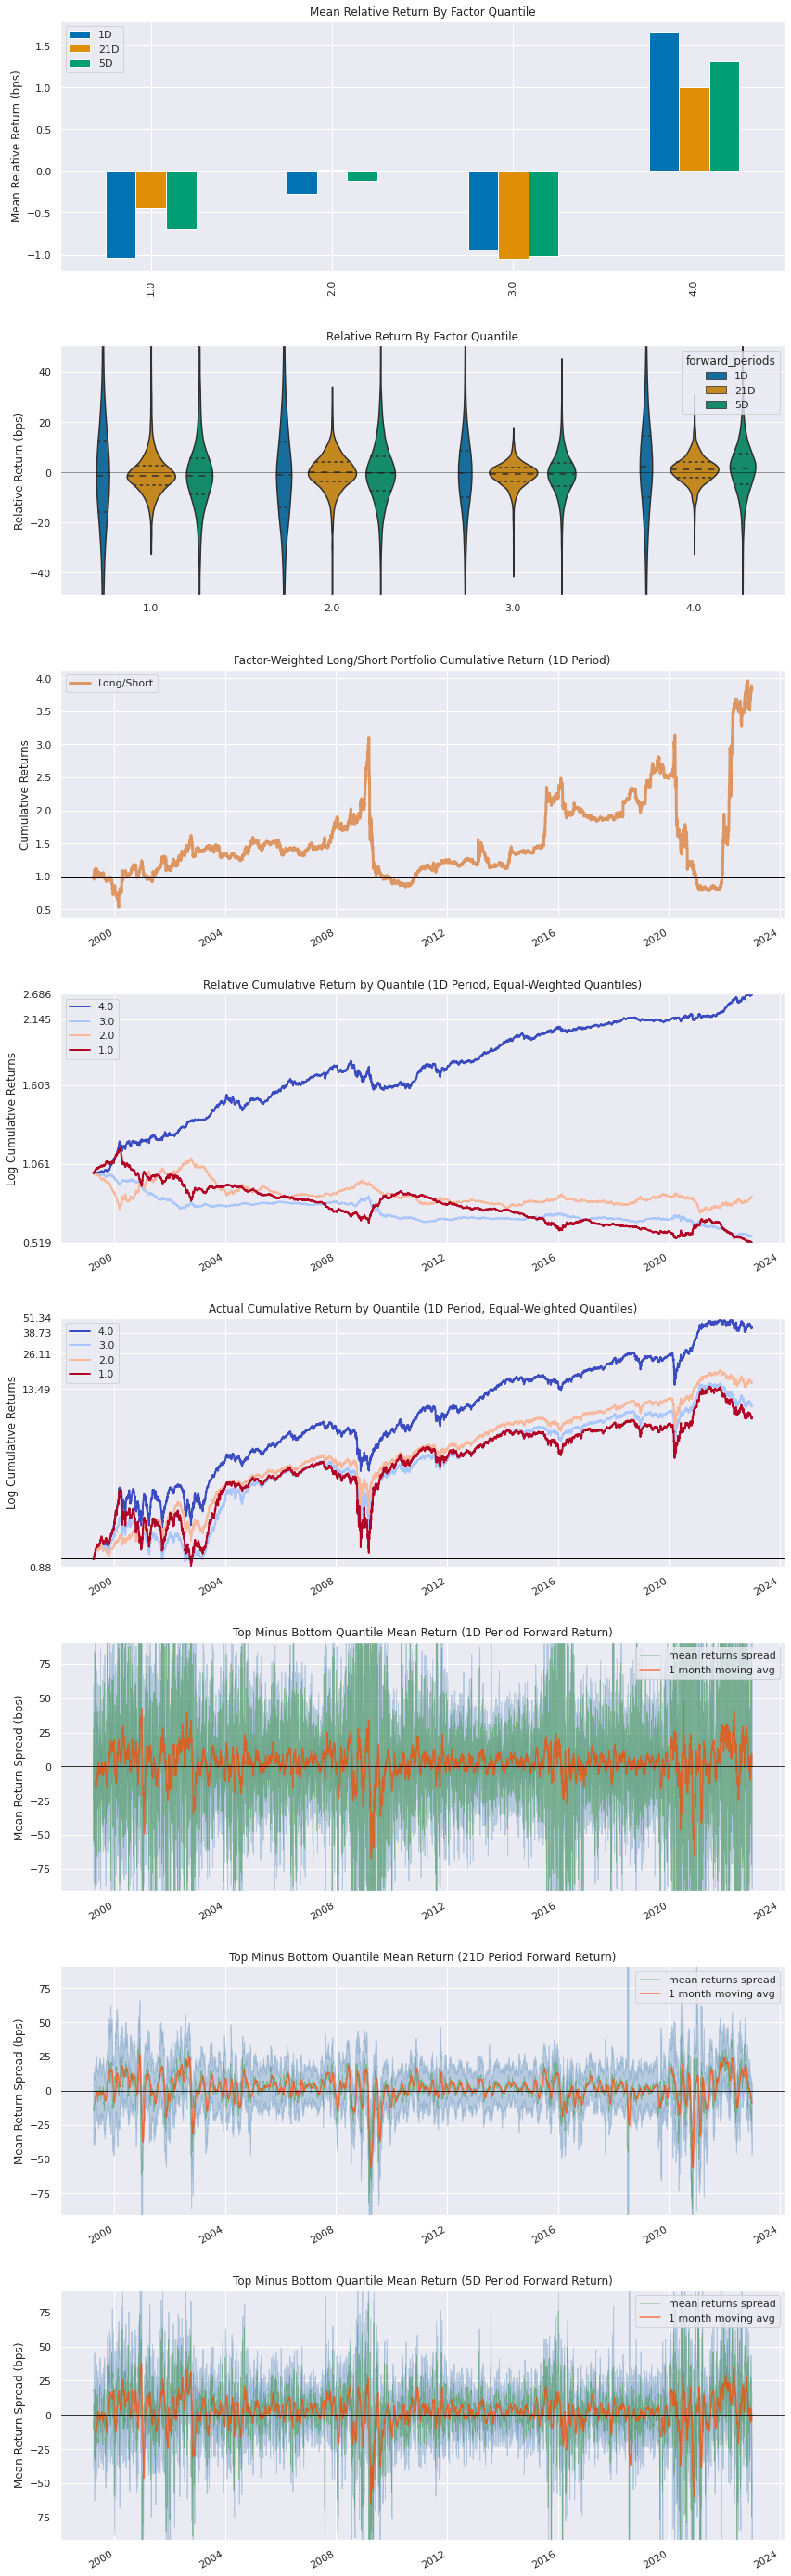

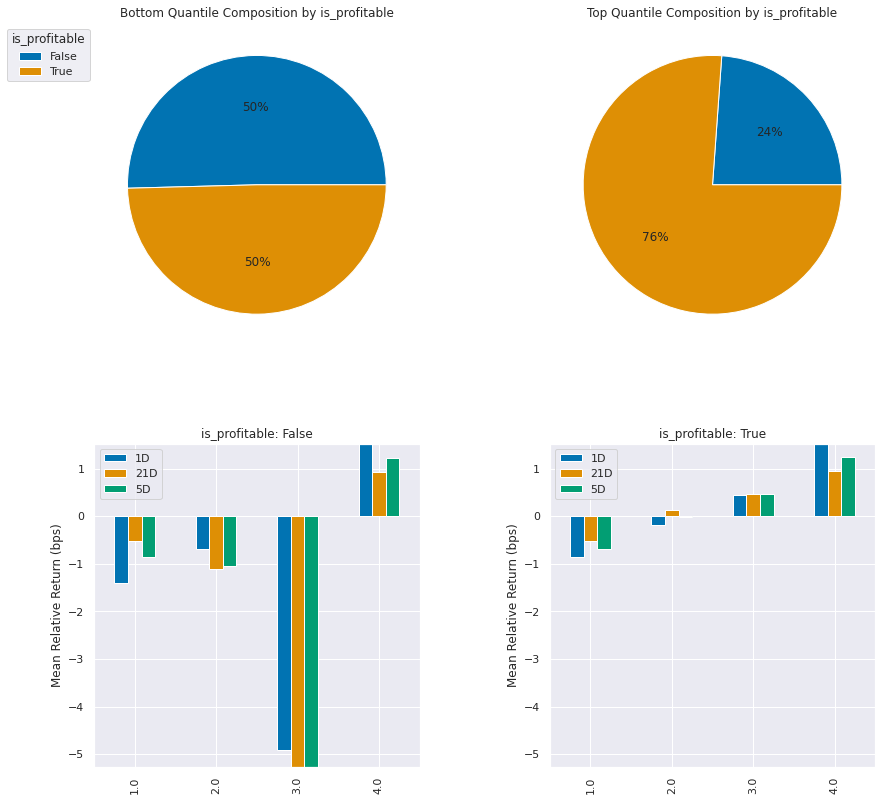

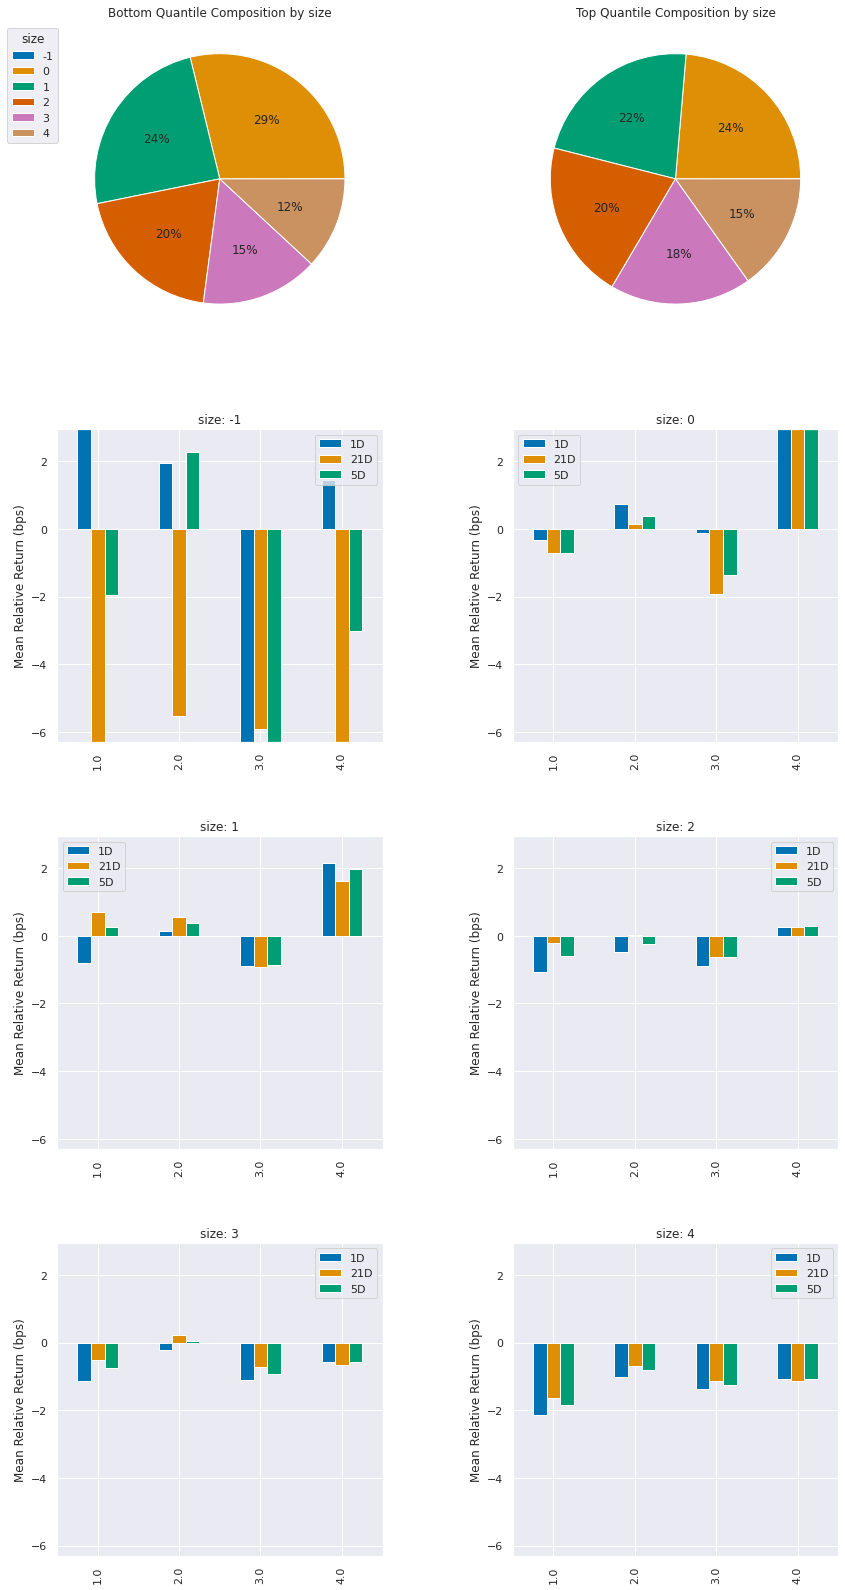

,1D,21D,5D
IC Mean,0.007,0.012,0.011
IC Std.,0.055,0.061,0.060
Risk-Adjusted IC,0.128,0.204,0.184
t-stat(IC),9.925,15.760,14.260
p-value(IC),0.000,0.000,0.000
IC Skew,-0.228,-0.758,-0.413
IC Kurtosis,1.606,2.290,1.438


/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


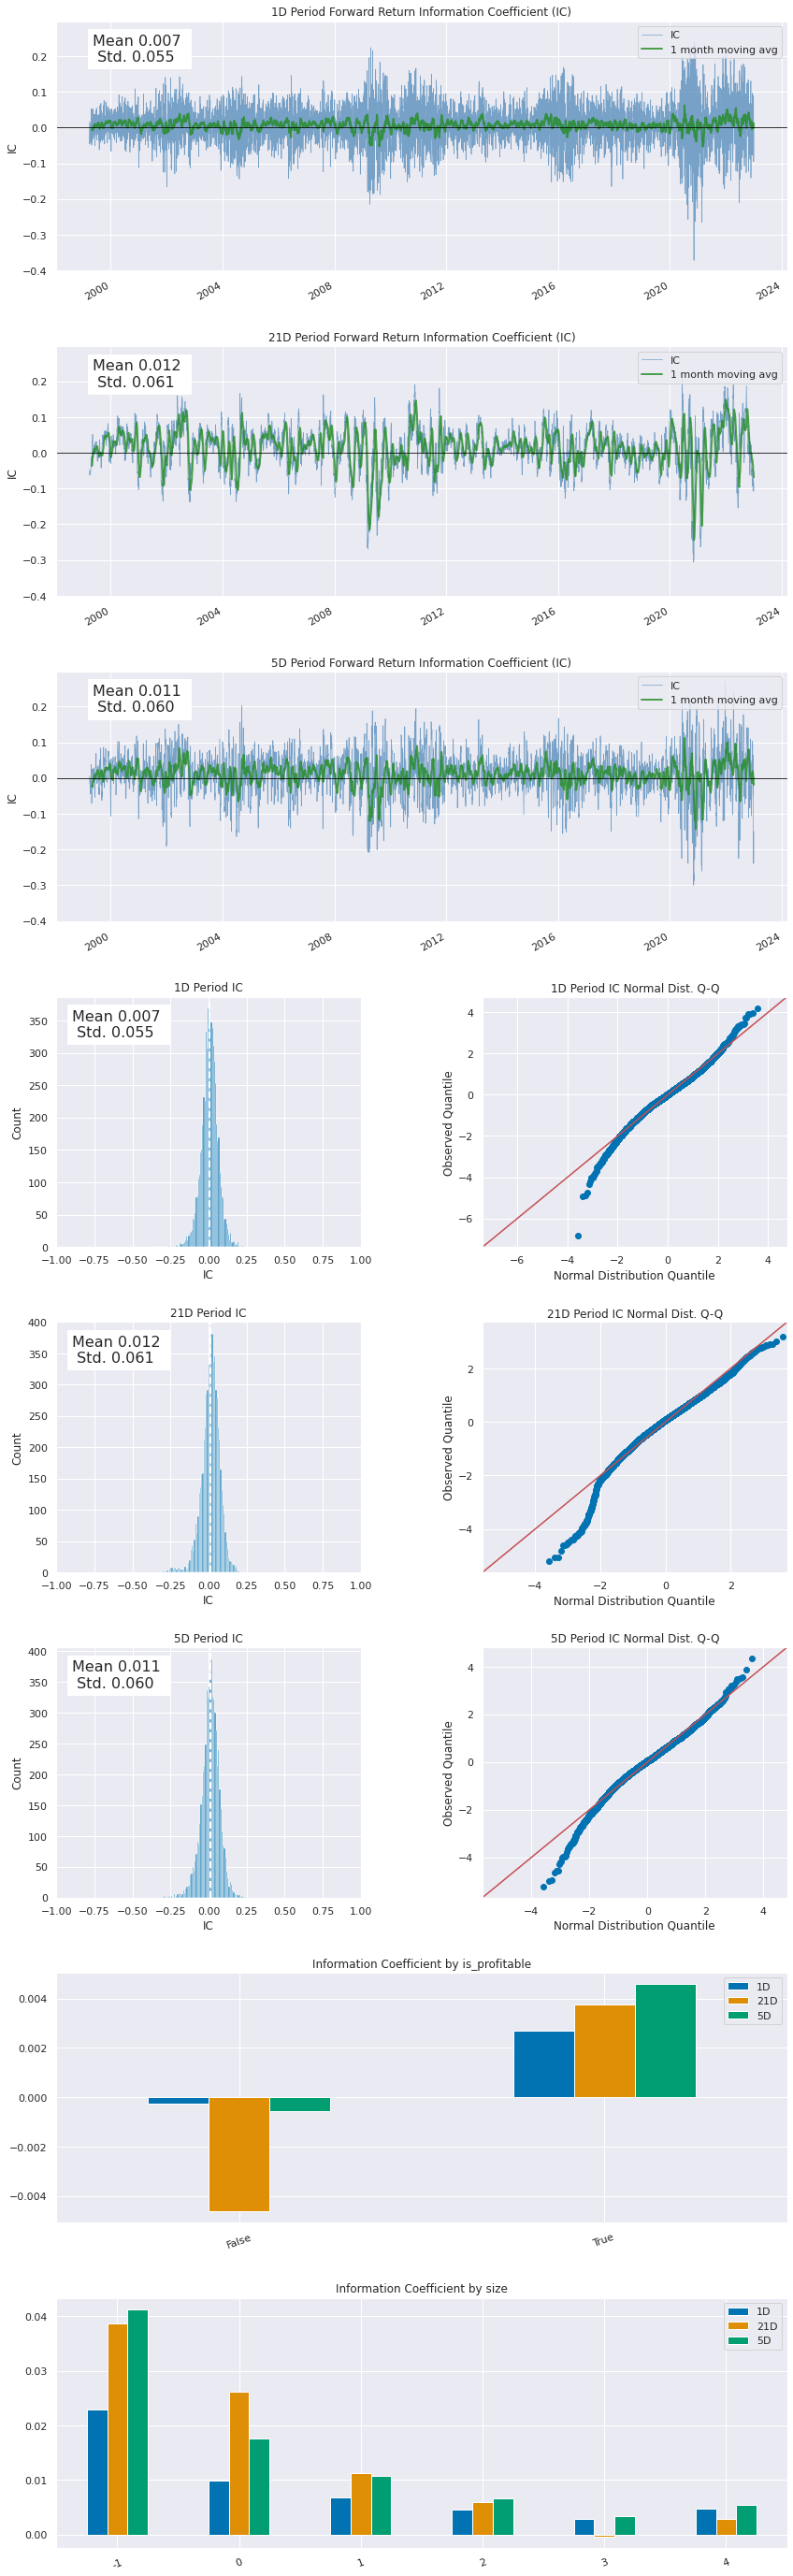

,1D,5D,21D
Quantile 1.0 Mean Turnover,0.008,0.037,0.135
Quantile 2.0 Mean Turnover,0.009,0.040,0.155
Quantile 3.0 Mean Turnover,0.009,0.040,0.151
Quantile 4.0 Mean Turnover,0.008,0.034,0.124


,1D,21D,5D
Mean Factor Rank Autocorrelation,0.995,0.9,0.976


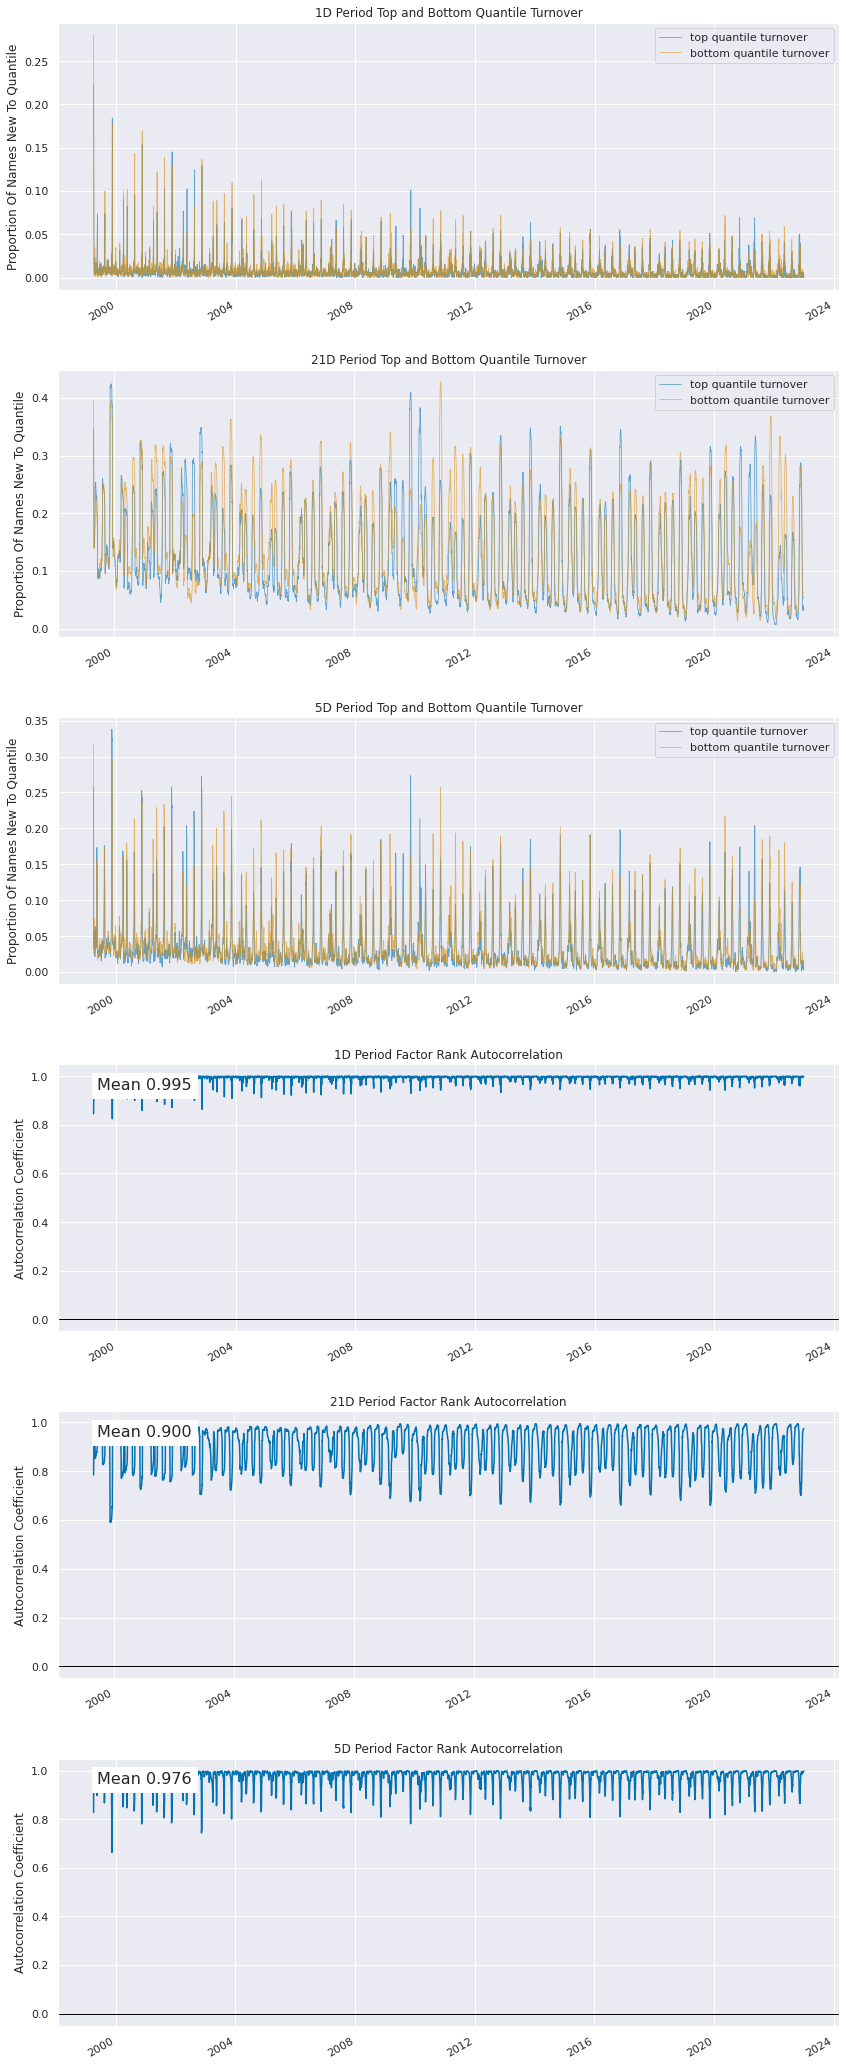

In [6]:
import alphalens as al

al.from_pipeline(
    pipeline,
    start_date="1999-02-01",
    end_date="2022-12-30",
    periods=[1, 5, 21],
    factor="profitability_growth",
    quantiles=4,
    zero_aware=True,
    groupby=[
        "is_profitable",
        "size"
    ],
    segment="Y"
)

## Tear sheet commentary

### Factor Distribution table

* `min`/`max`: The minimum value in quantile 1 and the maximum value in quantile 4 are very extreme, reflecting that we did not clip or winsorize the profitability growth factor (we only clipped the underlying operating margin factor.
* `count %`: The negative quantiles (quantiles 1 and 2) and the positive quantiles (quantiles 3 and 4) are more balanced in size than in the previous notebook, indicating that profitability is roughly equally likely to increase or decrease from year to year. 

### Returns Analysis

* `Table`: the mean spread of approx. 3 BPS between the top and bottom quantile is smaller than the approx. 6 BPS mean spread in the previous notebook.  
* `Mean Relative Return By Factor Quantile`: companies in the highest quantile of profitability growth perform better than other companies. Whereas most of the mean spread in the previous notebook was attributable to very poor performance in the bottom quantile (corresponding to companies with very negative operating margins), most of the mean spread in this notebook is attributable to superior performance in the highest quantile.
* `Relative Return by Factor Quantile`: in contrast to the bar charts, the violin plots show the density of returns for each factor quantile, not just the mean return. While the superior performance of factor quantile 4 was obvious in the bar chart, it's harder to see in the violin plot, as all the quantiles look fairly similar. This is a reminder that factor returns are very noisy, and a superior quantile is only superior on average. (The horizontal dashed line in each violin represents the mean return; if you look closely, you can see that quantile 4's dashed line is the highest.)
* `Factor-Weighted Long/Short Portfolio Cumulative Return`: the factor-weighted plot shows several very sharp up and down movements. This reflects that we did not clip or winsorize outliers, resulting in a highly concentrated portfolio due to the extreme minimum and maximum factor values (as indicated in the Factor Distribution table). This issue is discussed in more detail in the next notebook.
* `Relative Cumulative Return by Quantile`: this plot reiterates that the high profitability growth quantile outperformed the other quantiles on a relative basis. However, it appears that the bottom quantile outperformed during the 2009 post-GFC recovery. 
* `Top Minus Bottom Quantile Mean Return (21D Period Forward Return)`: looking for periods when the 1 month moving average of the mean spread falls below 0 makes it easy to spot periods when the bottom quantile (companies with worsening operating margins) outperformed the top quantile (companies with improving operating margins). Generally, these periods are associated with the initial recovery stage after deep market declines, such as the post-GFC recovery in 2009 and the post-Covid recovery in 2020.
* `Mean Relative Return plots by is_profitable`: factor quantile 4 (high growth in operating margin) performs similarly regardless of whether a company is profitable or unprofitable, and factor quantile 4 performs better than lower factor quantiles. This suggests that the trend in profitability matters more than the current level of profitability. It doesn't appear that there is an extra benefit to owning growing and already profitable companies over owning growing but not yet profitable companies. However, profitability growth impacts performance in a more predictable, monotonic way in the profitable subgroup than in the unprofitable subgroup, with the factor quantiles looking erractic in the unprofitable subgroup (quantile 3 is the worst). A takeaway might be that only the highest growth unprofitable companies are worth a look. If a company is only growing moderately, it's better for the company to be profitable than unprofitable.  
* `Mean Relative Return plots by size quantile`: size quantiles 0 and 1 (corresponding to the smallest 2/5th of companies) show strong relative returns in factor quantile 4. This means that small companies with growing profitability have good returns. In contrast, profitability growth doesn't provide a meaningful performance benefit in size quantiles 3 and 4 (corresponding to the largest 2/5th of companies). Here, the performance is roughly the same regardless of factor quantile. This suggests that profitability growth in a large company may just be noise that doesn't necessarily result in better forward performance. A large company is already large, so growth may not be as meaningful a metric for large companies as for small companies. On a side note, you might wonder how the bars for all four factor quantiles in size quantiles 3 and 4 can be negative. Remember, we are looking at relative returns in these plots, and they are relative to the mean return of the overall universe. In this particular tear sheet, the strong performance of small, growing stocks (factor quantile 4 in size quantiles 0 and 1) drives up the overall mean and results in all large stocks (size quantiles 3 and 4) performing below the mean.

***

## *Next Up*

Lesson 8: [Factor Values vs Factor Ranks](Lesson08-Factor-Values-vs-Factor-Ranks.ipynb)